In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb
import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset_Imgs, load_datasets, LabelConverter



In [2]:
def combine_into_one_df(pattern, get_label_num = None):
    listo = glob(pattern)

    dice_sens = []
    dice_spec = []
    overall_dice = []
    labels = []

    for x in listo:
        this_pkl = pd.read_pickle(x)
        if get_label_num is None:
            label_num = int(x.split('/')[-2].split('label')[1])
        else:
            label_num = get_label_num(x)

        labels.append(label_num)
        dice_sens.append(this_pkl['dice_sensitivity'].item())
        dice_spec.append(this_pkl['dice_specificity'].item())
        overall_dice.append(this_pkl['overall_dice'].item())

    total_df = pd.DataFrame({'dice_sensitivity': dice_sens,
                            'dice_specificity': dice_spec,
                            'overall_dice': overall_dice,
                            'label_numbers': labels})
    total_df = total_df.sort_values(by = 'label_numbers')
    return total_df
        


In [47]:
def collect_df(pattern):
    listo = glob(pattern)

    collector = {'label_number': [], 'pct_dataset': [], 'dice_sensitivity': [], 'dice_specificity': [], 'overall_dice': []}
    for x in listo:
        label = int(x.split('/')[-3])
        frac = float(x.split('/')[-2])
        this_pkl = pd.read_pickle(x)

        collector['label_number'].append(label)
        collector['pct_dataset'].append(frac)
        collector['dice_sensitivity'].append(this_pkl['dice_sensitivity'].item())
        collector['dice_specificity'].append(this_pkl['dice_specificity'].item())
        collector['overall_dice'].append(this_pkl['overall_dice'].item())


    total_df = pd.DataFrame(collector)
    total_df = total_df.sort_values(by = ['label_number', 'pct_dataset']).reset_index(drop=True)
    return total_df

def collect_df_repeat(pattern):
    listo = glob(pattern)

    collector = {'label_number': [], 'pct_dataset': [], 'repeat': [], 'dice_sensitivity': [], 'dice_specificity': [], 'overall_dice': []}
    for x in listo:
        label = int(x.split('/')[-4])
        frac = int(x.split('/')[-3])
        repeat = int(x.split('/')[-2])
        this_pkl = pd.read_pickle(x)

        collector['label_number'].append(label)
        collector['pct_dataset'].append(frac)
        collector['repeat'].append(repeat)
        collector['dice_sensitivity'].append(this_pkl['dice_sensitivity'].item())
        collector['dice_specificity'].append(this_pkl['dice_specificity'].item())
        collector['overall_dice'].append(this_pkl['overall_dice'].item())


    total_df = pd.DataFrame(collector)
    total_df = total_df.sort_values(by = ['label_number', 'pct_dataset', 'repeat']).reset_index(drop=True)
    return total_df

'''
pattern1 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subsets_expt_unet_9-12-24/val/0.0005/*/*/*.pkl'
unet_df = collect_df(pattern1)
unet_df['model'] = 'UNet'
'''

pattern2 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM/val/0.0005/*/*/*/*.pkl'
medsam_df = collect_df_repeat(pattern2)
medsam_df['model'] = 'MedSAM'
total_df = medsam_df
#total_df = pd.concat([medsam_df, unet_df], ignore_index=True)

In [48]:
total_df

,label_number,pct_dataset,repeat,dice_sensitivity,dice_specificity,overall_dice,model
0,1,1,0,0.771835,0.700042,0.730176,MedSAM
1,1,1,1,0.787713,0.696707,0.734905,MedSAM
2,1,1,2,0.783537,0.738492,0.757399,MedSAM
3,1,1,3,0.782905,0.729517,0.751925,MedSAM
4,1,1,4,0.722309,0.801686,0.768369,MedSAM
...,...,...,...,...,...,...,...
205,7,891,0,0.862070,0.994462,0.978179,MedSAM
206,7,891,1,0.862070,0.994462,0.978179,MedSAM
207,7,891,2,0.855419,0.997552,0.980071,MedSAM
208,7,891,3,0.855419,0.997552,0.980071,MedSAM


In [49]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)

In [ ]:
median_df = total_df.groupby(['label_number', 'pct_dataset', 'model']).agg({'dice_sensitivity': 'median'}).reset_index(drop=False)

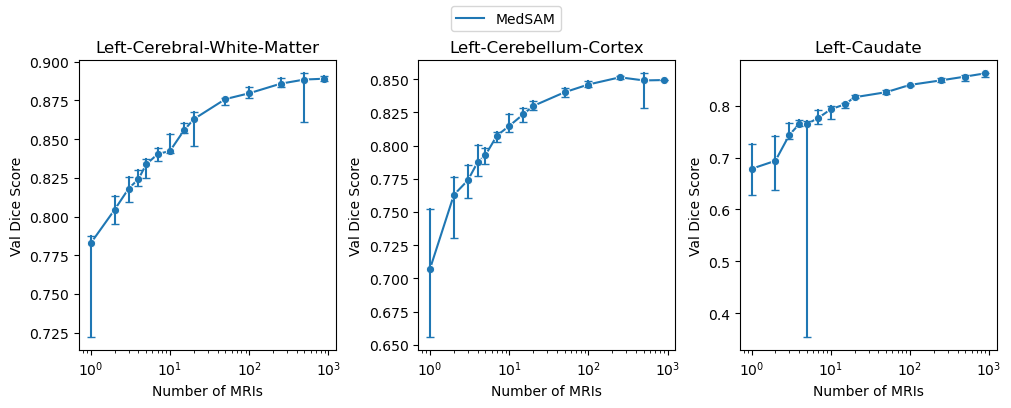

In [65]:
r = 1
c = 3
fig, axs = plt.subplots(r,c, layout='constrained', sharex=True, squeeze=False, figsize = (10, 4))
labels = [1,5,7]

filtered_df = total_df[total_df['dice_sensitivity'] >= 0.01]

#g = sns.FacetGrid(total_df, col = 'label_number', hue = 'model', col_wrap=4)
for idx, lab in enumerate(labels):
    i = idx // c
    j = idx % c
    
    xx = sns.lineplot(filtered_df[filtered_df['label_number'] == lab], x = 'pct_dataset', y = 'dice_sensitivity', hue = 'model', marker='o', ax = axs[i,j],
        estimator='median', legend = True if (i,j) == (0,0) else False, err_style='bars', err_kws={'capsize':3}, errorbar=('ci', 100))
    #sns.scatterplot(filtered_df[filtered_df['label_number'] == lab], x = 'pct_dataset', y = 'dice_sensitivity', hue='model', ax=axs[i,j], size = 0.3, palette='gray',
    #    legend = False)

    #xx = sns.pointplot(total_df[total_df['label_number'] == lab], x = 'pct_dataset', y = 'dice_sensitivity', hue = 'model', ax = axs[i,j], estimator='median',
    #    errorbar = lambda x: (x.min(), x.max()), dodge=True)

    #xx = sns.boxplot(total_df[total_df['label_number'] == lab], x = 'pct_dataset', y = 'dice_sensitivity', ax = axs[i,j])

    #xx = sns.lineplot(median_df[median_df['label_number'] == lab], x = 'pct_dataset', y = 'dice_sensitivity', hue = 'model', marker='o', ax = axs[i,j],
    #    legend = True if (i,j) == (0,0) else False)

    

    axs[i,j].set_xscale('log')
    axs[i,j].set_xlabel('Number of MRIs')
    axs[i,j].set_ylabel('Val Dice Score')
    axs[i,j].set_title(f'{label_converter.compressed_to_name(lab)}')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside upper center", ncol=2)
axs[0,0].get_legend().remove()
#plt.xscale('log')

fig.savefig('/gpfs/home/kn2347/figs/subset_analysis_medsam_vs_unet_new.pdf', dpi=300)
#g.map(sns.lineplot, 'pct_dataset', 'dice_sensitivity', marker='o')

#graph = sns.FacetGrid(total_df, x = 'pct_dataset', y = 'dice_sensitivity', col = 'label_number', marker='o')


In [13]:
num_train_mris = {}
for frac in [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]:
    num = len(pd.read_pickle(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/subset_train_id_dfs_pooled/{frac}.pkl')['train'])
    num_train_mris[frac] = num

total_df['num_mri'] = total_df['pct_dataset'].map(num_train_mris)

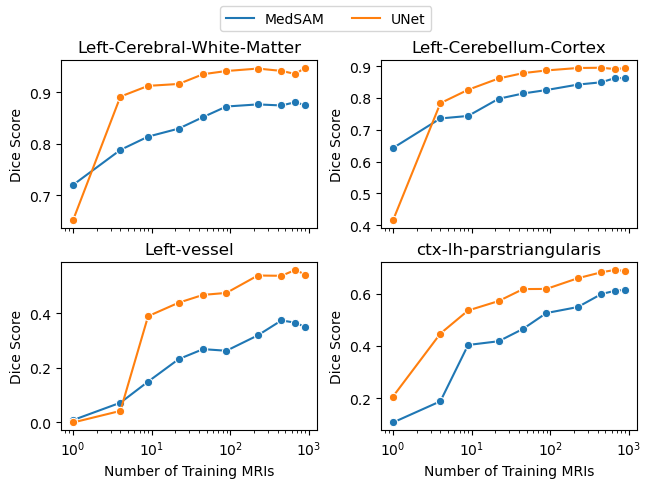

In [23]:
r = 2
c = 2
fig, axs = plt.subplots(r,c, layout='constrained', sharex=True)
labels = [1,5,18,58]
#g = sns.FacetGrid(total_df, col = 'label_number', hue = 'model', col_wrap=4)
for idx, lab in enumerate(labels):
    i = idx // c
    j = idx % c
    xx = sns.lineplot(total_df[total_df['label_number'] == lab], x = 'num_mri', y = 'dice_sensitivity', hue = 'model', marker='o', ax = axs[i,j],
        legend = True if (i,j) == (0,0) else False)

    axs[i,j].set_xscale('log')
    axs[i,j].set_xlabel('Number of Training MRIs')
    axs[i,j].set_ylabel('Dice Score')
    axs[i,j].set_title(f'{label_converter.compressed_to_name(lab)}')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside upper center", ncol=2)
axs[0,0].get_legend().remove()
plt.xscale('log')

fig.savefig('/gpfs/home/kn2347/figs/subset_analysis_medsam_vs_unet_11-6-24.pdf', dpi=300)
#g.map(sns.lineplot, 'pct_dataset', 'dice_sensitivity', marker='o')

#graph = sns.FacetGrid(total_df, x = 'pct_dataset', y = 'dice_sensitivity', col = 'label_number', marker='o')


Unet: Compare fulldf (using whole df) vs normaltrain

In [3]:
fulldf_pattern = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subsets_expt_unet_9-12-24/val/longtrain/*/*/*.pkl'
fulldf = collect_df(fulldf_pattern)

dfo = pd.merge(total_df[total_df['label_number'] == 1],fulldf, on=['label_number', 'pct_dataset'], how='inner', suffixes=['_without_full', '_with_full'])
dfo = pd.melt(dfo, id_vars=['label_number', 'pct_dataset'], value_vars=['dice_sensitivity_without_full', 'dice_sensitivity_with_full'], var_name='Dataset Type')
dfo['Dataset Type'] = dfo['Dataset Type'].map({
    'dice_sensitivity_without_full': 'Training using examples + 10% of non-examples',
    'dice_sensitivity_with_full': 'Training using examples + 100% of non-examples'
})
graph = sns.lineplot(dfo, x = 'pct_dataset', y = 'value', hue = 'Dataset Type', marker='o')
graph.set(xlabel = 'Percent of Dataset Used During Training',
            ylabel = 'Validation Dice Sensitivity')
#graph.legend.set(title='Dataset type used during training', labels=["Millennial", "Older Generations"])
#plt.legend(title=, loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


KeyboardInterrupt



### Yolov7 subsets

In [ ]:

listo = glob('/gpfs/home/kn2347/yolov10/runs/detect/yolov10_hcp_*/results.csv')

collector = []
interest = ['']

for xx in listo:
    frac = xx.split('/')[-2].split('_')[-1]
    df = pd.read_csv(xx, skipinitialspace=True)
    df['frac'] = frac
    collector.append(df)

yolov7_subset_training_df = pd.concat(collector)
#yolov7_subset_training_df['frac'] = yolov7_subset_training_df['frac'].astype(float)



In [ ]:
# plot mAP50 graph for assessment of overall performance
sns.lineplot(data = yolov7_subset_training_df, 
    x = 'epoch',
    y = 'metrics/mAP50(B)',
    hue = 'frac'
)

<Axes: xlabel='epoch', ylabel='metrics/recall(B)'>

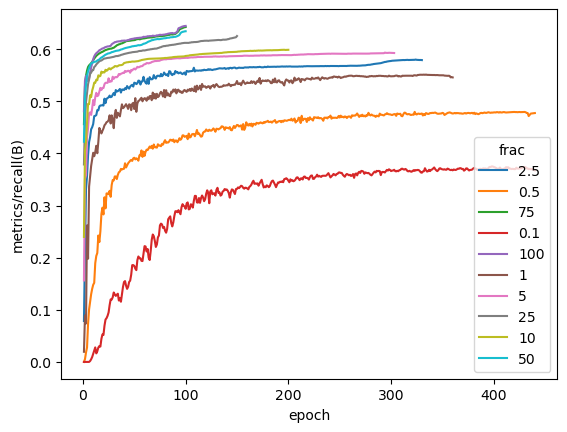

In [8]:
# plot recall graph to assess how good these models are at recognizing all the objects
sns.lineplot(data = yolov7_subset_training_df, 
    x = 'epoch',
    y = 'metrics/recall(B)',
    hue = 'frac'
)

In [64]:
# analyze per-class dataframes produced by yolov7 varying by fraction
dicto = {'label':[], 'frac': [], 'num_samples': []}
for class_num in range(1, 103):
    for frac in [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]:
        path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/yolov10/{frac}/{class_num}/path_df_only_with_bbox_yolov7.csv'
        thisdf = pd.read_csv(path, index_col=0)
        num = thisdf.shape[0]

        dicto['label'].append(class_num)
        dicto['frac'].append(frac)
        dicto['num_samples'].append(num)

sample_df = pd.DataFrame(dicto)

In [66]:
df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/training_set_class_statistics_10-15-24/class_statistics.csv')

sample_df['total_slices'] = [df[df['label'] == x]['total_slices'].item() for x in sample_df['label'].tolist()]
sample_df['fraction_of_total_slices'] = sample_df['num_samples'] / sample_df['total_slices']

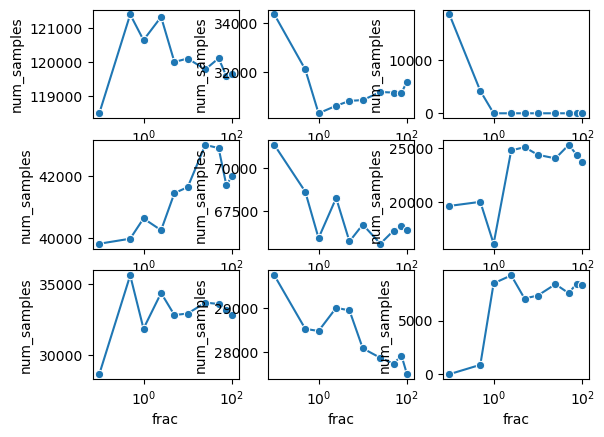

In [39]:


nc = 3
nr = 3
label = nr * nc
fig, axs = plt.subplots(nr, nc)

subdf = sample_df[sample_df['label'] <= label]

for i in range(1, label+1):
    ir = (i-1) // nc
    ic = (i-1) % nc
    sns.lineplot(subdf[subdf['label'] == i], x='frac', y='num_samples', marker='o', ax=axs[ir,ic], errorbar=None)
    axs[ir,ic].set_xscale('log')
    

#plt.yscale('log')
#plt.ylim(1e-1, 1e6)

In [67]:
import matplotlib.backends.backend_pdf
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)

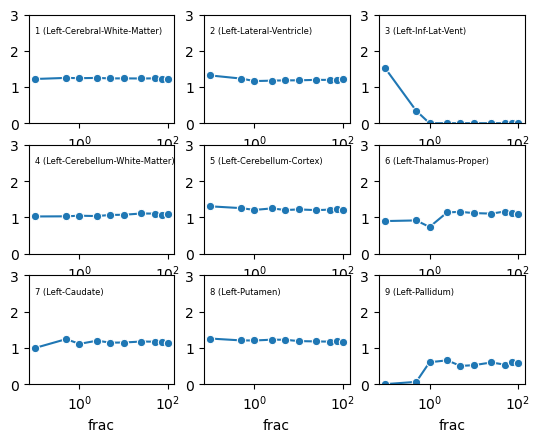

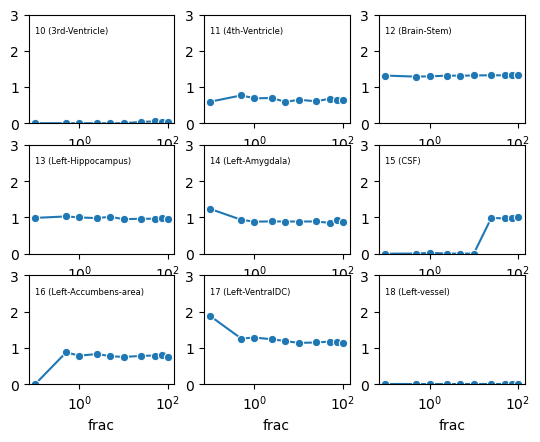

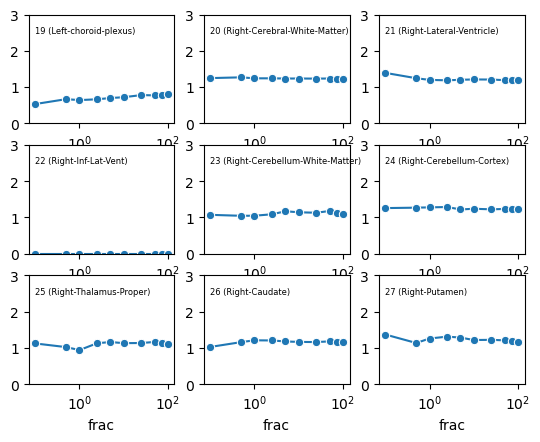

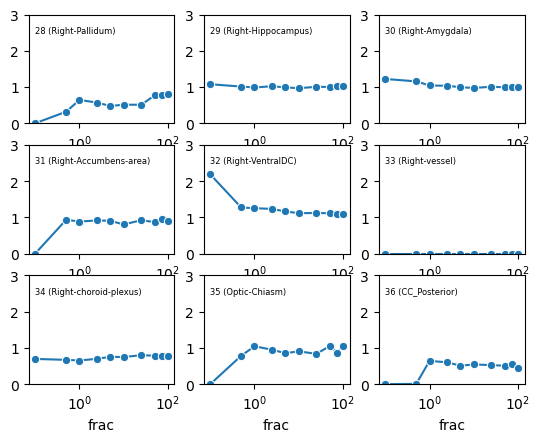

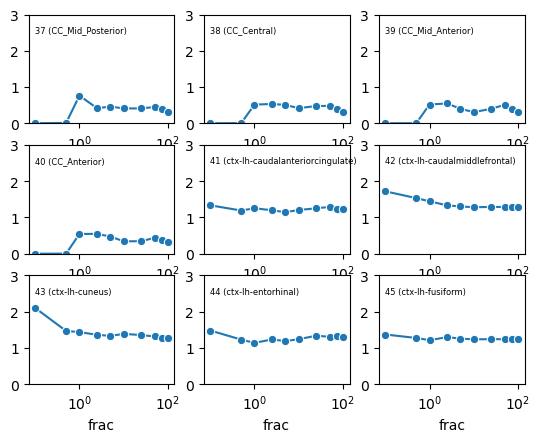

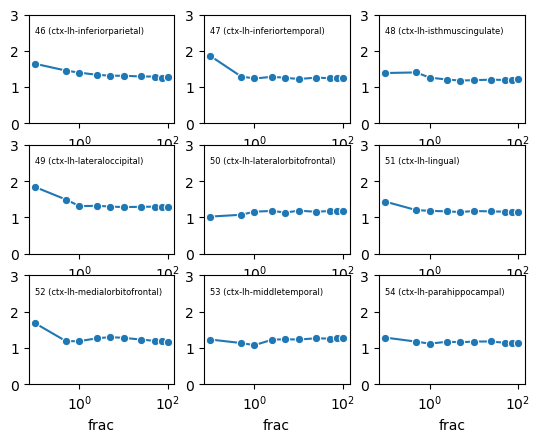

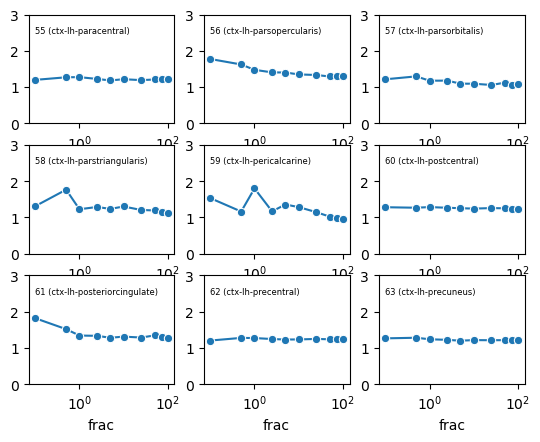

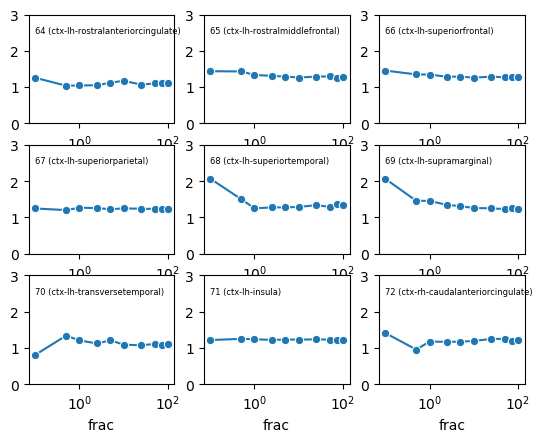

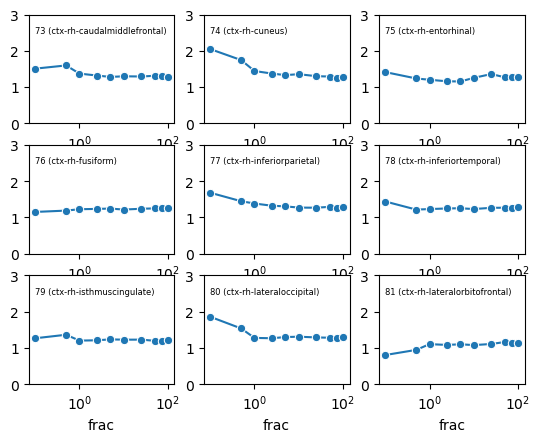

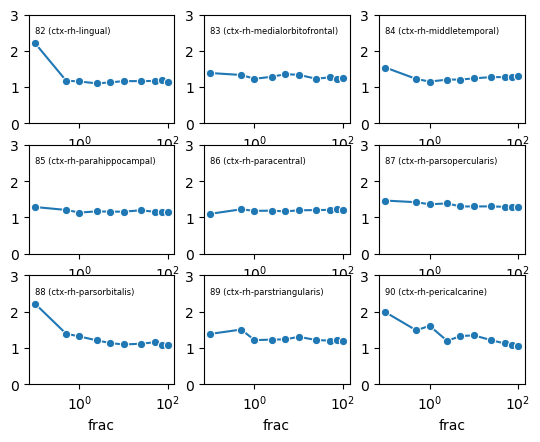

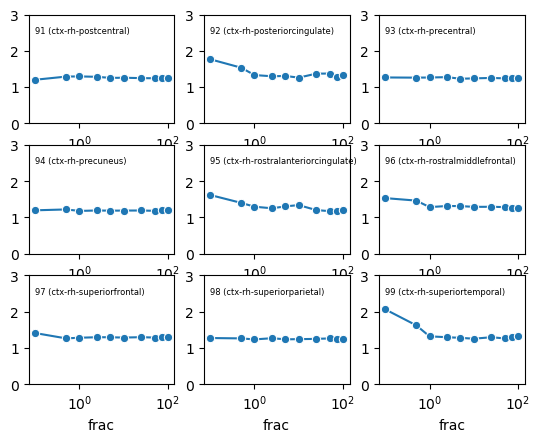

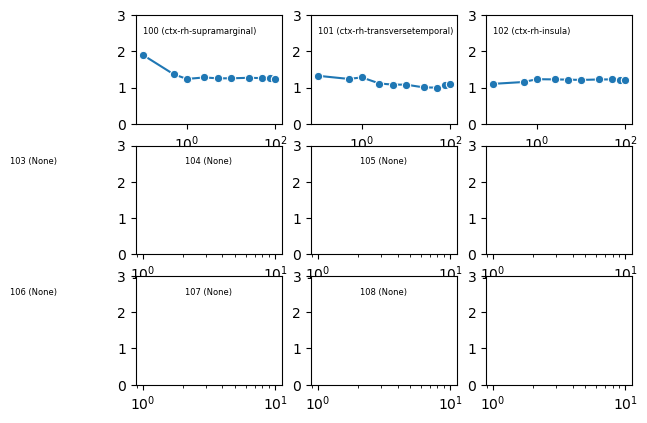

In [69]:

pdf = matplotlib.backends.backend_pdf.PdfPages("/gpfs/home/kn2347/figs/yolov7_subset_curves.pdf")

nc = 3
nr = 3

for st in range(1, 103, nr*nc):
    fig, axs = plt.subplots(nr, nc)

    subdf = sample_df[sample_df['label'].between(st, st + nr*nc-1)]
    ptr = 0
    for i in range(st, st + nr*nc):
        ir = ptr // nc
        ic = ptr % nc
        sns.lineplot(subdf[subdf['label'] == i], x='frac', y='fraction_of_total_slices', marker='o', ax=axs[ir,ic], errorbar=None)
        axs[ir,ic].set_xscale('log')
        #plt.yscale('log')
        axs[ir,ic].set_ylim(0, 3)
        axs[ir,ic].set_ylabel('') 
        axs[ir, ic].text(0.1, 2.5, f'{i} ({label_converter.compressed_to_name(i)})', fontsize=6)
        ptr += 1
    pdf.savefig(fig)
pdf.close()



In [76]:
pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/yolov10/0.1/1/path_df_only_with_bbox_yolov10.csv')

,id,slice,image_embedding_slice_path,segmentation_slice_path,image_path,bbox_0,bbox_1,bbox_2,bbox_3
0,100206,100,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,68,131,183,183
1,100206,101,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,69,130,184,183
2,100206,102,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,62,131,185,184
3,100206,103,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,61,130,186,185
4,100206,104,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,61,131,188,186
...,...,...,...,...,...,...,...,...,...
118491,989987,95,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,79,131,173,168
118492,989987,96,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,77,131,172,168
118493,989987,97,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,77,131,174,170
118494,989987,98,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,78,131,177,171


In [ ]:
# across all labels ... 
